In [1]:
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Dataset
import math
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from Datasets import VariableLengthDataset, IncrementalDataset
from models import BigTransformer, BigTransformerAgent, IncrementalAgent, IncrementalProbAgent
from StockDataWrapper import get_time_series

# Hyperparameters

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
tickers = ["AAPL"]
data_dir = "../data_combined/"
test_days = 100
lag_days = 30
batch_size = 128

# model params
indim = 23
outdim = 1
hidden_dim = 256
d_model = 64
nhead = 8
num_encoder_layers = 6
num_decoder_layers = 6


In [ ]:
train = VariableLengthDataset(tickers=tickers, data_dir=data_dir, lag_days=lag_days, test_days=test_days, test=False)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

test = VariableLengthDataset(tickers=tickers, data_dir=data_dir, lag_days=lag_days, test_days=test_days, test=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)


In [ ]:
agent = BigTransformerAgent(indim=23, outdim=23, hidden_dim=256, d_model=64, nhead=8, num_encoder_layers=6, num_decoder_layers=6, device=device, 
                            checkpoint_dir='../saved_models/23outdimMSEmodel', init_lr=0.001, lr_decay=0.0001, min_lr=0.0000025, decay_lr_every=20)

In [ ]:
agent.train(train_loader, 500)

In [ ]:
agent = IncrementalAgent(indim=23, outdim=23, hidden_dim=256, d_model=64, nhead=8, num_encoder_layers=6, num_decoder_layers=6, device=device, 
                            checkpoint_dir='../saved_models/23outdimIncrementalMSEmodel', init_lr=0.0001, lr_decay=0.5, min_lr=0.00000025, decay_lr_every=10, 
                            tickers=tickers)

In [ ]:
gt, preds, companies = agent.train(test_days, 20)

In [11]:
agent = IncrementalProbAgent(indim=23, outdim=1, hidden_dim=256, d_model=64, nhead=8, num_encoder_layers=6, num_decoder_layers=6, device=device, 
                            checkpoint_dir='../saved_models/incrementalBCE_AAPL', init_lr=0.0001, lr_decay=0.5, min_lr=0.00000025, decay_lr_every=10, 
                            tickers=tickers)


In [12]:
true_labels, predicted_scores, companies = agent.train(100, 15) # one column for each company ticker, flatten to compute ROC over all
fpr, tpr, thresholds = roc_curve(true_labels.reshape(-1), predicted_scores.reshape(-1))
roc_auc = auc(fpr, tpr)

Test Day 0, Epoch 1, Loss: 465.7565; Average Loss: 0.6017525849108241; lr: [0.0001]
Test Day 0, Epoch 2, Loss: 465.7785; Average Loss: 0.6017810488240047; lr: [0.0001]
Test Day 0, Epoch 3, Loss: 466.7027; Average Loss: 0.6029750247334325; lr: [0.0001]
Test Day 0, Epoch 4, Loss: 465.8919; Average Loss: 0.601927554576588; lr: [0.0001]
Test Day 0, Epoch 5, Loss: 466.4434; Average Loss: 0.6026401113170062; lr: [0.0001]
Test Day 0, Epoch 6, Loss: 465.0092; Average Loss: 0.6007870919328635; lr: [0.0001]
Test Day 0, Epoch 7, Loss: 466.8204; Average Loss: 0.603127186304531; lr: [0.0001]
Test Day 0, Epoch 8, Loss: 466.8270; Average Loss: 0.6031356252133077; lr: [0.0001]
Test Day 0, Epoch 9, Loss: 466.5988; Average Loss: 0.6028408800908761; lr: [0.0001]
Test Day 0, Epoch 10, Loss: 466.1216; Average Loss: 0.6022242495563911; lr: [0.0001]
Test Day 0, Epoch 11, Loss: 465.6758; Average Loss: 0.6016482832511882; lr: [0.0001]
Test Day 0, Epoch 12, Loss: 466.2190; Average Loss: 0.6023501930926813; lr: 

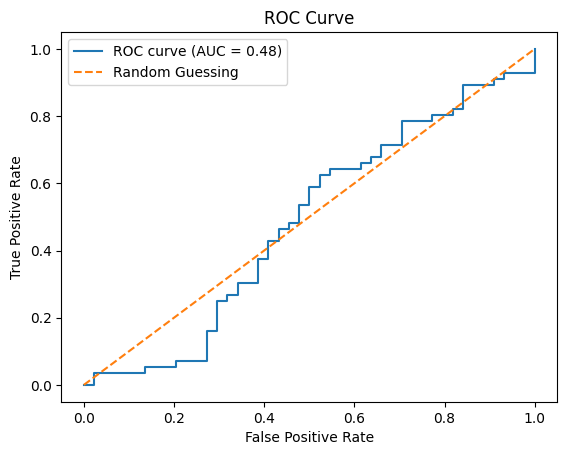

In [18]:
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Testing

In [14]:
def directional_accuracy_prob(gt, pred):
    """Calculates directional accuracy of given ground truth and 
    prediction percent change series.
    From Kaeley et al.
    
    inputs:
        gt: ground truth pct_change
        pred: predicted probability of positive pct_change
        
    returns:
        acc: directional accuracy of predicted values
    """
    pred[pred > 0.5] = 1
    pred[pred <= 0.5] = 0
    return np.sum(gt == pred) / len(gt)

In [17]:
gt = np.load(os.path.join('..','saved_models', 'incrementalBCE_AAPL', 'returns', 'ground_truths_05-05_13-27-46.npy'))
preds = np.load(os.path.join('..','saved_models', 'incrementalBCE_AAPL', 'returns', 'predictions05-05_13-27-46.npy'))

num_increasing = np.sum(true_labels) / len(true_labels.ravel())
da = directional_accuracy_prob(true_labels, predicted_scores)
print(f"{tickers[0]} Directional Accuracy: {da:.2%}, Percent of days with upward price movement: {num_increasing:.2%}")

# for j in range(gt.shape[1]): # columns correspond to each company
#     num_increasing = np.sum(gt) / len(gt.ravel())
#     da = directional_accuracy_prob(gt[:,j], preds[:,j])
#     print(f"{tickers[j]} Directional Accuracy: {da:.2%}, Percent of days with upward price movement: {num_increasing:.2%}")

AAPL Directional Accuracy: 44.00%, Percent of days with upward price movement: 56.00%
